In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


sql_context = sqlContext

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


""" Collaborative Filtering class to serve recommendations
Notice: The input are implicit rating objects - not explicit ones.
"""

import numpy as np
from numpy import linalg as alg

from operator import add
from pyspark.mllib.recommendation import Rating, ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Row
from pyspark.sql.functions import col

class CollaborativeFiltering():

    def __init__(self, rank=20, lmbda=0.01, n_iterations=10):
        """
        :rank (int): Rank of the feature matrices computed (number of features)
        :iterations (int): Number of iterations of ALS
        :lmda (float): Regularization parameter. (default: 0.01)
        """

        # CF parameters
        self.rank = rank
        self.lmbda = lmbda
        self.n_iterations = n_iterations


        # internal data structures needed for CF
        self.user_column = 'user'
        self.item_column = 'item'
        self.rating_column = 'rating'
        self.user_index_column = 'user_index'
        self.item_index_column = 'item_index'
        self.df_ratings = None
        self.rdd_ratings = None

        # The CF model itself
        self.model = None

        # Auxilliary data strucutres
        self.annoy_index = None
        self.annoy_trees = None


    def _get_rating_matrix_info(self, df,
                               user_column, user_index_column,
                               item_column, item_index_column,
                               rating_column):
        """ Preprocess data in order to get the ratings rdd (user, item, rating)
        :df (Spark DataFrame): The input DataFrame holding the user/item data
        :user_column (string): The user column name
        :user_index_column (string): The user index column name
        :item_column (string): The item column name
        :item_index_column (string): The item index column name
        :rating_column (string): The rating column name
        input e.g.
        +----+----+
        |user|item|
        +----+----+
        |   A| id1|
        |   A| id3|
        |   B| id1|
        |   C| id5|

        output ratings data frame e.g.
        +----+------+----+----------+----------+
        |item|rating|user|user_index|item_index|
        +----+------+----+----------+----------+
        | id5|     1|   C|         2|         2|
        | id1|     1|   B|         1|         0|
        | id3|     1|   A|         0|         1|

        output ratings rdd e.g.
        [Rating(user=2, product=2, rating=1.0),
         Rating(user=2, product=4, rating=1.0),
         Rating(user=1, product=5, rating=1.0), ...]

        """

        # clear data
        # e.g. user has seen only one item - does not contribute to collborative intelligence
        user_items_df = \
            df.rdd.groupByKey()\
                  .map(lambda (user, items): (user, len(items)))\
                  .map(lambda (user, n_items): Row(user=user, n_items=n_items))\
                  .toDF()
        df = df.join(user_items_df, [user_column])
        df = df.filter(df['n_items'] > 1).select([user_column, item_column])


        # Get ratings matrix
        # +----+------+----+
        # |item|rating|user|
        # +----+------+----+
        # | id5|     1|   C|
        # | id6|     1|   C|
        # | id4|     1|   B|
        df_ratings = df.rdd\
            .map(lambda (user, item): ((user, item), 1))\
            .reduceByKey(add)\
            .map(lambda ((user, item), rating): Row(user=user, item=item, rating=rating))\
            .toDF()

        # Index user / item values for ALS input
        # we cast explicitly to integer. If not result is real and ALS performance drops dramatically
        df_ratings = StringIndexer(inputCol=user_column,
                                   outputCol=user_index_column,
                                   handleInvalid="skip")\
            .fit(df_ratings)\
            .transform(df_ratings)\
            .withColumn(user_index_column, col(user_index_column).cast("integer"))

        df_ratings = StringIndexer(inputCol=item_column,
                                   outputCol=item_index_column,
                                   handleInvalid="skip")\
            .fit(df_ratings)\
            .transform(df_ratings)\
            .withColumn(item_index_column, col(item_index_column).cast("integer"))

        # get ratings rdd
        rdd_ratings = df_ratings\
            .select([user_index_column, item_index_column, rating_column])\
            .rdd.map(lambda (user, item, rating): Rating(user, item, rating))

        return df_ratings, rdd_ratings


    def train(self, df):
        """ Training of Collabrative Filtering model.
        This is a wrapper, see details in doc strings of functions below
        :df (Spark DataFrame): The input DataFrame holding the user/item data
        input e.g.
        +----+----+
        |user|item|
        +----+----+
        |   A| id1|
        |   A| id3|
        |   B| id1|
        |   C| id5|
        """

        # get rating objects
        (self.df_ratings, self.rdd_ratings) = self._get_rating_matrix_info(df,
            self.user_column, self.user_index_column,
            self.item_column, self.item_index_column,
            self.rating_column)

        # train the ALS model (implicit because we have implicit ratings)
        self.model = ALS.trainImplicit(self.rdd_ratings,
                                  self.rank,
                                  self.n_iterations,
                                  self.lmbda)


    def recommend_products(self, n_top_products):
        return self.model.recommendProductsForUsers(n_top_products).collect()

In [3]:
"""
Data input is a user-item DataFrame (implies that we want to use the implicit CF mathods)
As we see we construct our data in such a way that we will be able to valide the reconstruction of the latent space.

"""
df = sql_context.createDataFrame([( 'Tom', 'red_shoes'),  
                                  ( 'Tom', 'red_pen'),
                                  ( 'Tom', 'red_bag'),
                                  
                                  ( 'Christian', 'blue_drone'),
                                  ( 'Christian', 'blue_watch'),
                                  ( 'Christian', 'blue_headphones'),
                                  
                                  ( 'Mary', 'red_shoes'),  
                                  ( 'Mary', 'red_hat'),
                                  ( 'Mary', 'red_bag'),
                                  
                                  ( 'Joe', 'yellow_boots'),  
                                  ( 'Joe', 'yellow_ombrella'),
                                  ( 'Joe', 'yellow_book'),
                                                                    
                                  ( 'Nick', 'blue_drone'),
                                  ( 'Nick', 'blue_glasses'),
                                  ( 'Nick', 'blue_headphones')
                                 ], 
                                 [ "user", "item"])

print "We have N distinct users: ", df.select('user').distinct().count()
print "We have N distinct items: ", df.select('item').distinct().count()

We have N distinct users:  5
We have N distinct items:  11


In [4]:
# We want to perform CF and reducing on the same time the space of the latent factors to 2
RANK = 2
sql_context = sqlContext
cf = CollaborativeFiltering(rank=RANK)
cf.train(df)
print cf.df_ratings.take(2)

[Row(item=u'blue_headphones', rating=1, user=u'Nick', user_index=2, item_index=1), Row(item=u'yellow_ombrella', rating=1, user=u'Joe', user_index=0, item_index=9)]


In [5]:
# we can see now how our users are distributed in the latent space
df_user_latent = sql_context.createDataFrame(cf.model.userFeatures(), 
                                             ['user_index', 'user_latent_vec'])
df_user_latent.show(2)

+----------+--------------------+
|user_index|     user_latent_vec|
+----------+--------------------+
|         0|[0.05661938339471...|
|         1|[-0.9209058880805...|
+----------+--------------------+
only showing top 2 rows



In [6]:
# we can merge the user - user ids 
df_user_info = cf.df_ratings.select(['user', 'user_index'])
df_user_info.show(2)

+----+----------+
|user|user_index|
+----+----------+
|Nick|         2|
| Joe|         0|
+----+----------+
only showing top 2 rows



In [7]:
df_user_latent = df_user_latent.join(df_user_info, ['user_index'])
df_user_latent.show(2)

+----------+--------------------+----+
|user_index|     user_latent_vec|user|
+----------+--------------------+----+
|         0|[0.05661938339471...| Joe|
|         0|[0.05661938339471...| Joe|
+----------+--------------------+----+
only showing top 2 rows



In [8]:
latent_d = df_user_latent.rdd.map(lambda (user_index, user_latent_vec, user): ((user_index, user), user_latent_vec)).collectAsMap()
print latent_d

{(4, u'Mary'): [-0.9209057688713074, 0.3492300808429718], (3, u'Christian'): [0.23279984295368195, 1.305754542350769], (0, u'Joe'): [0.05661938339471817, -0.028040017932653427], (2, u'Nick'): [0.2327985167503357, 1.3057550191879272], (1, u'Tom'): [-0.9209058880805969, 0.34922975301742554]}


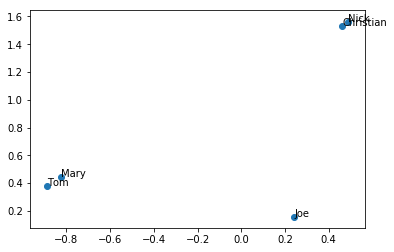

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random

x = []
y = []
annotations = []
for k, v in latent_d.iteritems():
    # we add on purpose a tiny noise fuctor so not to have overlaping points
    epsilon = random.uniform(0, 0.3)
    x.append(v[0]+epsilon)
    y.append(v[1]+epsilon)
    user = k[1]
    annotations.append(user)
        
fig, ax = plt.subplots()
plt.scatter(x, y)

for i, a in enumerate(annotations):
    plt.annotate(a, (x[i], y[i]))
    
plt.show()

As we see, although we have not any explicit information about the data (we only know that people have preference in colors but this is only inferred from the name of the product itself) the latent space shows the different "clusters" of users.
There is Mary and Tom in one side that like Red,  while Christian and Nick like the blue, and there is Joe that has not any common items with the rest (and hypothetically she likes another collor).For Joe The results would have been the same even if the name of the product had nothing of color information in it of course. It is just enough that Joe has no item in common with the rest to place her somehwere alone in the latent space.